In [326]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as seabornInstance
import scipy as sp

import matplotlib.pyplot as plt

from pandas_datareader import data
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [327]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
#tickers = ['^GSPC', 'MSFT']

# We would like all available data from 01/01/2000 until 12/31/2016.
#start_date = '2010-01-01'
#end_date = '2016-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
#panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
#panel_data.tail()

In [328]:
# for i in range(10):
#     try:
#         sp = yf.Ticker("^GSPC").history(period="max")
#         break
#     except:
#         print("failed attempt {}".format(i))
        
# sp.to_csv("sp500_1927-2020_daily.csv", index=True)

sp = pd.read_csv("sp500_1927-2020_daily.csv", index_col=0)
sp.index = pd.to_datetime(sp.index)

In [329]:
# Getting just the adjusted closing prices. This will return a Pandas DataFrame
# The index in this DataFrame is the major index of the panel_data.
close = sp[['Close','Dividends']]

# Getting all weekdays between 01/01/2000 and 12/31/2016
#all_weekdays = pd.date_range(start=close.index[0], end=close.index[-1], freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
#close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
#close = close.fillna(method='ffill')

# Change to SP500 lable
#close = close.rename(columns={'^GSPC':'SP500'})

In [330]:
#trades['idx'] = np.arange(len(trades))
#row0_1 = True

# Simple Trading Scheme
def trade_on_regimes(row, prior_row):
#     global row0_1
#     if row0_1:
#         row0_1 = False
#         return(row)
    
    #print("row: {}".format(row.idx))
    #print("Regime: {}".format(row.Regime))
    
    # Set the current asset value based on current equity price
    row.Asset_Value = row.Close*prior_row.Asset_Count
    #print("Start value={}".format(row.Asset_Value))
    
    available_balance = prior_row.Balance
    #print("Start Balance={}".format(available_balance))
    
    if row.Regime == "LowVol":
        #print(row.Close)
        shares = np.floor(1*available_balance/row.Close)
        #print(shares)
        cost_of_shares = shares*row.Close
        #print(cost_of_shares)
        row.Balance = available_balance - cost_of_shares
        row.Asset_Value+=cost_of_shares
        row.Asset_Count =prior_row.Asset_Count + shares
        
    elif row.Regime == "Trans":   # Buy half of balance
        #print(row.Close)
        shares = np.floor(0.05*available_balance/row.Close)
        #print(shares)
        cost_of_shares = shares*row.Close
        #print(cost_of_shares)
        row.Balance = available_balance - cost_of_shares
        row.Asset_Value+=cost_of_shares
        row.Asset_Count =prior_row.Asset_Count + shares
        
    else:    # Sell all shares
        shares_sold = np.floor(1*prior_row.Asset_Count)
        sale_price = shares_sold*row.Close
        row.Balance = available_balance + sale_price
        row.Asset_Value = prior_row.Asset_Value - sale_price
        row.Asset_Count= prior_row.Asset_Count - shares_sold
    
    #print("closing val={}".format(row.Asset_Value))
    #print("closing balance={}".format(row.Balance))
    #print('')

    return(row)

In [331]:
def buy(row, prior_row, sizeB, asset):
    row.Asset_Value = row.Close*prior_row.Asset_Count # Fix for multiple assets
    available_balance = prior_row.Balance
    
    shares = np.floor(sizeB*available_balance/row[asset])
    cost_of_shares = shares*row[asset]
    
    row.Balance = available_balance - cost_of_shares
    row.Asset_Value+=cost_of_shares
    row.Asset_Count =prior_row.Asset_Count + shares
    
    return(row)

def sell(row, prior_row, sizeS, asset):
    row.Asset_Value = row.Close*prior_row.Asset_Count    # Fix for multiple assets
    available_balance = prior_row.Balance
    
    shares_sold = np.floor(sizeS*prior_row.Asset_Count)
    sale_price = shares_sold*row.Close
    
    row.Balance = available_balance + sale_price
    row.Asset_Value = prior_row.Asset_Value - sale_price
    row.Asset_Count = prior_row.Asset_Count - shares_sold
    
    return(row)

In [332]:
# Trade on regimes using buy and sell functions
lv_size = 1
lvt_size = .66
tt_size = .33
hvt_size = 1
hv_size = 1

def trade_on_regimes(row, prior_row, lv_size, lvt_size, tt_size, hvt_size, hv_size):
    if row.Regime == "LowVol":
        row = buy(row, prior_row, lv_size, "Close")
    elif ((row.Regime == "Trans") & (prior_row.Regime == "LowVol")):
        row = sell(row, prior_row, lvt_size, "Close")
    elif ((row.Regime == "Trans") & (prior_row.Regime == "Trans")):
        row = sell(row, prior_row, tt_size, "Close")
    elif ((row.Regime == "Trans") & (prior_row.Regime == "HighVol")):
        row = buy(row, prior_row, hvt_size, "Close")
    else:
        row = sell(row, prior_row, hv_size, "Close")
        
    return(row)

In [333]:
starting_capital=100000

trades = close

#regimes = pd.read_csv("regimes.csv")
#trades['Regime'] = list(regimes.state)
preds = pd.read_csv("state_predictions_mid19.csv", index_col=0)

trades=trades.iloc[-len(preds):,:]

trades['Regime'] = list(preds.state_predictions)

#trades=trades.iloc[1500:5500]

# Add in columns for leveraged funds
# sso = list(pd.read_csv("SSO.csv", index_col=0)['Adj Close'])
# ssl = np.pad(sso, (len(trades)-len(sso),0), 'constant', constant_values=(1e6))
# trades['LevClose'] = ssl

# trades = trades[trades.LevClose < 1e5]
# End add leveraged columns

trades['Bench_Returns'] = trades.Close/trades.Close.shift(1, axis=0)
trades['Bench_Cumprod'] = trades.Bench_Returns.cumprod()

# trades.Close = trades.LevClose



shares = np.floor(starting_capital/1.1/trades["Close"].iloc[0])
price = trades["Close"].iloc[0]

trades['Asset_Count'] = shares
trades['Asset_Value'] = shares*price
trades['Balance'] = starting_capital-shares*price

initial_trades = trades.copy(deep=True)

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [334]:
# for i in range(1,len(trades)):
#     old_row=trades.iloc[i-1,:]
    
#     current_row=trades.iloc[i,:]
    
#     trades.iloc[i,:] = trade_on_regimes(current_row, old_row, lv_size, lvt_size, tt_size, hvt_size, hv_size)
    
# trades['Account_Value'] = trades['Balance']+trades['Asset_Value']
# trades['Performance_Returns'] = trades.Account_Value/trades.Account_Value.shift(1, axis=0)
# trades['Performance_Cumprod'] = trades.Performance_Returns.cumprod()

# trades.to_csv("trades_review.csv")

In [335]:
# #trades=trades.iloc[-500:,:]

# # Plot everything by leveraging the very powerful matplotlib package
# fig, ax = plt.subplots(figsize=(16,9))

# ax.plot(trades.index, trades.Performance_Cumprod, label='Trades')
# ax.plot(trades.index, trades.Bench_Cumprod, label='SP500')

# ax.set_title('Return Multiple starting with ${}'.format(starting_capital))
# ax.set_xlabel('Date')
# ax.set_ylabel('Multiple')
# ax.legend()

In [336]:
from joblib import Parallel, delayed
import multiprocessing
from functools import partial

In [337]:
def get_final_multiple(lv_size, lvt_size, tt_size, hvt_size, hv_size):
    import scipy as sp
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    
    global initial_trades
    trades = initial_trades.copy(deep=True)
    
    for i in range(1,len(trades)):
        old_row=trades.iloc[i-1,:]

        current_row=trades.iloc[i,:]

        trades.iloc[i,:] = trade_on_regimes(current_row, old_row, lv_size, lvt_size, tt_size, hvt_size, hv_size)
        
    trades['Account_Value'] = trades['Balance']+trades['Asset_Value']
    trades['Performance_Returns'] = trades.Account_Value/trades.Account_Value.shift(1, axis=0)
    trades['Performance_Cumprod'] = trades.Performance_Returns.cumprod()
    
    trades.Bench_Returns = trades.Bench_Returns - 1
    trades.Performance_Returns = trades.Performance_Returns - 1
    regressor = LinearRegression()  
    x = np.array(trades.Bench_Returns.iloc[1:]).reshape(-1, 1)
    y = np.array(trades.Performance_Returns.iloc[1:])
    regressor.fit(x, y) #training the algorithm
    #To retrieve the intercept:
    alpha = regressor.intercept_
    #For retrieving the slope:
    beta=regressor.coef_
    
    avg = np.mean(y)
    sd = np.std(y)
    skw = sp.stats.skew(y)
    kur = sp.stats.kurtosis(y)
    
    sharpe = (np.mean(y-x))/sd
    
    final_multiple = trades.Performance_Cumprod.iloc[-1]
    
    return(lv_size, lvt_size, tt_size, hvt_size, hv_size, final_multiple, alpha, beta, avg, sd, skw, kur, sharpe)

In [338]:
step = 3
thirds = [0,.33,.66,1]
lv_sizes = [.8,1]#list(np.arange(0,10,step)/10)
lvt_sizes = [.8,1]#list(np.arange(0,10,step+1)/10)
tt_sizes = [.33]#list(np.arange(0,10,step+1)/10)
hvt_sizes = thirds#list(np.arange(0,10,step+1)/10)
hv_sizes = [.66,1]#list(np.arange(5,10,step)/10)

# lv_sizes.append(1.0)
# lvt_sizes.append(1.0)
# tt_sizes.append(1.0)
# hvt_sizes.append(1.0)
# hv_sizes.append(1.0)

num_cores = multiprocessing.cpu_count()



In [339]:
output = Parallel(n_jobs=num_cores)(delayed(get_final_multiple)(lv_size=i, lvt_size=j, tt_size=k, hvt_size=l, hv_size=m) for i in tqdm(lv_sizes) for j in lvt_sizes for k in tt_sizes for l in hvt_sizes for m in hv_sizes)
#output = Parallel(n_jobs=num_cores)(delayed(get_final_multiple)(lv_size=i, lvt_size=0, tt_size=0, hvt_size=0, hv_size=.5) for i in tqdm(lv_sizes))# for j in lvt_sizes for k in tt_sizes for l in hvt_sizes for m in hv_sizes)
out = pd.DataFrame(output, columns=['lv','lvt','tt','hvt','hv','final_mult','alpha','beta','avg','std','skew','kurt','sharpe'])


100%|██████████| 2/2 [00:43<00:00, 21.77s/it]


In [340]:
outsort = out.sort_values(by=['sharpe'], ascending=False)
outsort.head(10)

,lv,lvt,tt,hvt,hv,final_mult,alpha,beta,avg,std,skew,kurt,sharpe
31,1.0,1.0,0.33,1.00,1.00,6.442048,0.000242,[0.09092435470332068],0.000270,0.003698,-0.015285,6.106148,-0.010796
30,1.0,1.0,0.33,1.00,0.66,6.405636,0.000241,[0.09156173066408303],0.000269,0.003706,-0.014461,6.332595,-0.010983
29,1.0,1.0,0.33,0.66,1.00,6.355953,0.000239,[0.09089203936061357],0.000268,0.003609,0.067915,4.873396,-0.011682
28,1.0,1.0,0.33,0.66,0.66,6.317974,0.000238,[0.09130196975645576],0.000267,0.003612,0.066475,4.914191,-0.011903
15,0.8,1.0,0.33,1.00,1.00,6.250439,0.000237,[0.09008371055180785],0.000265,0.003666,-0.025643,6.133765,-0.012084
14,0.8,1.0,0.33,1.00,0.66,6.220856,0.000237,[0.09067338214925616],0.000265,0.003672,-0.023231,6.368036,-0.012242
27,1.0,1.0,0.33,0.33,1.00,6.269895,0.000237,[0.09082171683232496],0.000265,0.003555,0.104639,4.856271,-0.012454
26,1.0,1.0,0.33,0.33,0.66,6.243012,0.000237,[0.09121139481244468],0.000265,0.003559,0.102938,4.845435,-0.012605
13,0.8,1.0,0.33,0.66,1.00,6.168048,0.000235,[0.09002511931725253],0.000263,0.003575,0.058830,4.840692,-0.013010
25,1.0,1.0,0.33,0.00,1.00,6.169038,0.000235,[0.0911196480171464],0.000263,0.003538,0.112905,4.983329,-0.013176


In [341]:
outsort.to_csv("output_multiples_.csv")

C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

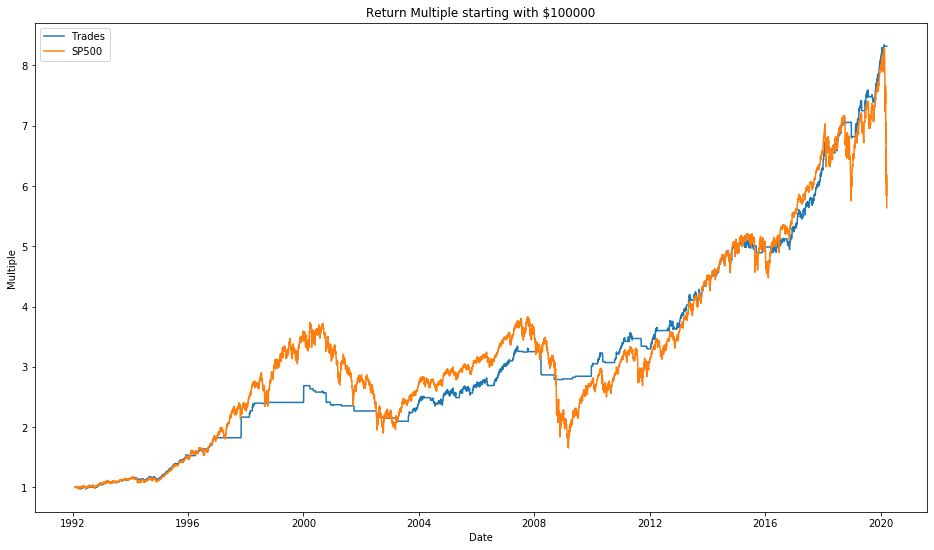

In [346]:
r=0
lv_size = 1#outsort.iloc[r,0]
lvt_size = .3#outsort.iloc[r,1]
tt_size = 0#outsort.iloc[r,2]
hvt_size = .3#outsort.iloc[r,3]
hv_size = 1#outsort.iloc[r,4]

for i in range(1,len(trades)):
    old_row=trades.iloc[i-1,:]
    
    current_row=trades.iloc[i,:]
    
    trades.iloc[i,:] = trade_on_regimes(current_row, old_row, lv_size, lvt_size, tt_size, hvt_size, hv_size)
    
trades['Account_Value'] = trades['Balance']+trades['Asset_Value']
trades['Performance_Returns'] = trades.Account_Value/trades.Account_Value.shift(1, axis=0)
trades['Performance_Cumprod'] = trades.Performance_Returns.cumprod()

trades.to_csv("trades_review.csv")

#trades=trades.iloc[-500:,:]

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(trades.index, trades.Performance_Cumprod, label='Trades')
ax.plot(trades.index, trades.Bench_Cumprod, label='SP500')

ax.set_title('Return Multiple starting with ${}'.format(starting_capital))
ax.set_xlabel('Date')
ax.set_ylabel('Multiple')
ax.legend()

In [347]:
yearly = (trades.iloc[-1,-1]**(252/len(trades))-1)*100
print("geometric yearly rate = {}".format(yearly))

geometric yearly rate = 7.8220952723746295


In [ ]:
# Probably need 4 states
# 1996-2000 is positive tt
# 200002003 is negative tt